In [ ]:
import torch

print("Torch version:",torch.__version__)
print("Is CUDA enabled?",torch.cuda.is_available())

device = torch.device("cuda")

In [ ]:
!pip install transformers numpy==1.25 scipy==1.11

In [ ]:
from transformers import BartForConditionalGeneration, BartTokenizer, BartConfig, BartModel, AdamW
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.nn import L1Loss, MSELoss
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import time
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler
import pickle
from scipy.optimize import curve_fit

In [ ]:
class DynamicDatasetTorch(Dataset):
    def __init__(self, size, noise_level, signal_lenght, step_max_level=64000):
        self.size = size
        self.signal_lenght = signal_lenght

    def __len__(self):
        return self.size

    def __getitem__(self, index):
        mi = torch.rand(1).item() * 4 - 2
        sigma = torch.rand(1).item() * 0.99 + 0.01 
        x = torch.linspace(-5, 5, self.signal_lenght)
        gaussian_curve = torch.exp(-0.5 * ((x - mi) / sigma) ** 2)
        gaussian_curve /= torch.max(gaussian_curve)

        level = torch.randint(0, 11, (1,)).item()  # Losowy poziom szumu od 0 do 10
        noise = torch.normal(mean=0, std=(10 - level) * 0.01, size=(self.signal_lenght,)) 

        x = gaussian_curve + noise   # inputs
        y = gaussian_curve + 0.5 * noise   # targets

        return x, y, gaussian_curve


In [ ]:
emb_dim = 128

bart_config = BartConfig(
    d_model = emb_dim,  # Nowy rozmiar embeddings
    encoder_attention_heads=1, 
    decoder_attention_heads=1,
    encoder_layers=1, 
    decoder_layers=1,
    vocab_size = 128, 
    activation_function = 'gelu'
)

bart_model = BartModel(config=bart_config)

In [ ]:
# Model definition
class CustomBARTModel(nn.Module):
    def __init__(self):    
        super(CustomBARTModel, self).__init__()
        self.dense_input = nn.Linear(1, emb_dim)  # input embedding
        self.bart_model = bart_model.eval() # transformers
        self.dense_output = nn.Linear(emb_dim, 1)  # output embedding

    def forward(self, x):
        x1 = x[..., None] # [batch x seqlen] to [batch x seqlen x 1])
        x2 = self.dense_input(x1)  # [batch x seqlen x 1] to [batch x seqlen x emb_dim]

        x3 = self.bart_model(
            input_ids=None,
            inputs_embeds=x2[:, :, :],
            decoder_input_ids=None,
            decoder_inputs_embeds=x2[:, :, :],
            return_dict=True
        ) 
        x4 = self.dense_output(x3['last_hidden_state'])[..., 0]  # [batch x seqlen x 1] back to [batch x seqlen]
        return x4

In [ ]:
train_losses = []
val_losses = []
val_mae = []
eval_losses = []

In [ ]:
# Training
slen = 256
num_epochs = 20
train_dataset_size = 100000 
validation_dataset_size = 50000 
custom_bart_model = CustomBARTModel()

optimizer = torch.optim.AdamW(custom_bart_model.parameters(), lr=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-06, verbose=False)

loss_fn = torch.nn.L1Loss() # MAE L1Loss MSE MSELoss

In [111]:
# Wariant I

custom_bart_model.to(device)

level = 1
print(f"Validating for level {level}")

batch_size = 8

dynamic_train_dataset = DynamicDatasetTorch(train_dataset_size, noise_level=None, signal_lenght=slen, step_max_level=batch_size*1000)
dynamic_validation_dataset = DynamicDatasetTorch(validation_dataset_size, level, slen)

train_dataloader = DataLoader(dynamic_train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(dynamic_validation_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(num_epochs):
    start_time = time.time()

    total_loss = 0.0
    for x_batch, y_batch, gauss in train_dataloader:
        x_batch, y_batch = x_batch.to(device).float(), y_batch.to(device).float()

        optimizer.zero_grad()
        y_pred = custom_bart_model(x_batch)  # Konwertuj dane wejściowe na FloatTensor
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    average_loss = total_loss / len(train_dataloader)
    train_losses.append(average_loss)

    end_time = time.time()
    epoch_time = end_time - start_time

    custom_bart_model.eval()

    total_val_loss = 0.0
    total_val_mae = 0.0

    with torch.no_grad():
        for x_val, y_val, gauss in validation_dataloader:
            x_val, y_val = x_val.to(device).float(), y_val.to(device).float()

            y_val_pred = custom_bart_model(x_val)

            val_loss = loss_fn(y_val_pred, y_val)
            total_val_loss += val_loss.item()
            total_val_mae += val_loss.item()           

    val_loss = total_val_loss / len(validation_dataloader)
    val_mae_value = total_val_mae / len(validation_dataloader)
    val_losses.append(val_loss)
    val_mae.append(val_mae_value)

    print(f"Epoch {epoch + 1}: Loss: {loss:.5f}, Val_loss: {val_loss:.5f}, Time: {epoch_time:.5f} seconds") 

    before_lr = optimizer.param_groups[0]["lr"]
    scheduler.step(val_loss)
    after_lr = optimizer.param_groups[0]["lr"]
    print("Epoch %d: AdamW lr %.6f -> %.6f" % (epoch+1, before_lr, after_lr))

    custom_bart_model.train()

Validating for level 1
Epoch 1: Loss: 0.00819, Val_loss: 0.00905, Time: 208.61675 seconds
Epoch 1: AdamW lr 0.000100 -> 0.000100
Epoch 2: Loss: 0.00858, Val_loss: 0.01014, Time: 207.43599 seconds
Epoch 2: AdamW lr 0.000100 -> 0.000100
Epoch 3: Loss: 0.00628, Val_loss: 0.00791, Time: 206.15440 seconds
Epoch 3: AdamW lr 0.000100 -> 0.000100
Epoch 4: Loss: 0.00594, Val_loss: 0.00672, Time: 204.71447 seconds
Epoch 4: AdamW lr 0.000100 -> 0.000100
Epoch 5: Loss: 0.00467, Val_loss: 0.00537, Time: 204.68873 seconds
Epoch 5: AdamW lr 0.000100 -> 0.000100
Epoch 6: Loss: 0.00519, Val_loss: 0.00574, Time: 206.63796 seconds
Epoch 6: AdamW lr 0.000100 -> 0.000100
Epoch 7: Loss: 0.00450, Val_loss: 0.00588, Time: 206.72465 seconds
Epoch 7: AdamW lr 0.000100 -> 0.000100
Epoch 8: Loss: 0.00399, Val_loss: 0.00493, Time: 206.31020 seconds
Epoch 8: AdamW lr 0.000100 -> 0.000100
Epoch 9: Loss: 0.00457, Val_loss: 0.00520, Time: 210.77738 seconds
Epoch 9: AdamW lr 0.000100 -> 0.000100
Epoch 10: Loss: 0.00391

Walidacja i ocena

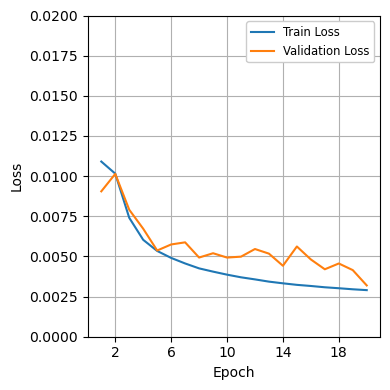

In [113]:
# Rysowanie wykresu straty
plt.figure(figsize=(4, 4))

plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.ylim(0, 0.02)
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Wymuszenie wartości całkowitych na osi X
plt.xticks(range(2, num_epochs + 1, 4))

# Dodanie legendy
plt.legend(loc='upper right', fontsize='small', framealpha=1)
plt.grid(True)

# Dostosowanie odstępów między wykresami
plt.tight_layout()

# Zapisanie wykresu do pliku
plt.savefig('loss.jpg')

plt.show()

In [115]:
# Ocena na zbiorze walidacyjnym
validation_dataset_size = 200
dynamic_validation_dataset = DynamicDatasetTorch(validation_dataset_size, level, slen)
validation_dataloader = DataLoader(dynamic_validation_dataset, batch_size=batch_size, shuffle=False)
iter_nums = 10
mse_loss_fn = nn.MSELoss()
custom_bart_model.eval()
average_val_loss = 0.0
average_val_loss_gauss = 0.0
eval_losses = []
signals_prediction = []
iter_num = 0
total_val_loss_gauss = 0.0

with torch.no_grad():
    for x_batch, y_batch, gauss in validation_dataloader:
        x_batch, y_batch, gauss = x_batch.to(device), y_batch.to(device), gauss.to(device)
        val_y_pred = x_batch.float()
        print("\n")
        
        val_loss_gauss = torch.sqrt(mse_loss_fn(val_y_pred, gauss)) # RMSE, uwaga, uśrednione dla batch
        eval_losses.append(val_loss_gauss)    
        print(f"Iteration {iter_num}: Loss Gauss: {val_loss_gauss.item():.5f}")

        signals_prediction.append(gauss) # pierwszy
        signals_prediction.append(val_y_pred) # drugi
        
        #total_val_loss = 0.0
        #total_val_loss_gauss = 0.0    
        
        for iter_num in range(1,iter_nums+1): #10

            val_y_pred = custom_bart_model(val_y_pred)  
            val_loss_gauss = torch.sqrt(mse_loss_fn(val_y_pred, gauss)) # RMSE, # uwaga, uśrednione dla batch
            eval_losses.append(val_loss_gauss)

            print(f"Iteration {iter_num}: Loss Gauss: {val_loss_gauss.item():.5f}")

            signals_prediction.append(val_y_pred)
   
        total_val_loss_gauss += val_loss_gauss.item() # dodaj z ostatniego cyklu
        average_val_loss_gauss = total_val_loss_gauss / len(validation_dataloader)

    print(f"\nValidation Loss Gauss (10, average): {average_val_loss_gauss:.5f}") # średni wynik z ostatniego cyklu

# Zapisywanie do pliku
with open('signals_prediction.pkl', 'wb') as f: # gauss i val_y_pred 10x (batch_size)
    pickle.dump(signals_prediction, f)
with open('eval_losses.pkl', 'wb') as f: # dla każdego kroku
    pickle.dump(eval_losses, f)



Iteration 0: Loss Gauss: 0.03590
Iteration 1: Loss Gauss: 0.01960
Iteration 2: Loss Gauss: 0.01285
Iteration 3: Loss Gauss: 0.01201
Iteration 4: Loss Gauss: 0.01388
Iteration 5: Loss Gauss: 0.01657
Iteration 6: Loss Gauss: 0.01952
Iteration 7: Loss Gauss: 0.02253
Iteration 8: Loss Gauss: 0.02558
Iteration 9: Loss Gauss: 0.02864
Iteration 10: Loss Gauss: 0.03170


Iteration 10: Loss Gauss: 0.05728
Iteration 1: Loss Gauss: 0.03035
Iteration 2: Loss Gauss: 0.01773
Iteration 3: Loss Gauss: 0.01345
Iteration 4: Loss Gauss: 0.01376
Iteration 5: Loss Gauss: 0.01580
Iteration 6: Loss Gauss: 0.01833
Iteration 7: Loss Gauss: 0.02102
Iteration 8: Loss Gauss: 0.02375
Iteration 9: Loss Gauss: 0.02650
Iteration 10: Loss Gauss: 0.02926


Iteration 10: Loss Gauss: 0.05152
Iteration 1: Loss Gauss: 0.02803
Iteration 2: Loss Gauss: 0.01710
Iteration 3: Loss Gauss: 0.01356
Iteration 4: Loss Gauss: 0.01399
Iteration 5: Loss Gauss: 0.01595
Iteration 6: Loss Gauss: 0.01839
Iteration 7: Loss Gauss: 0.02101


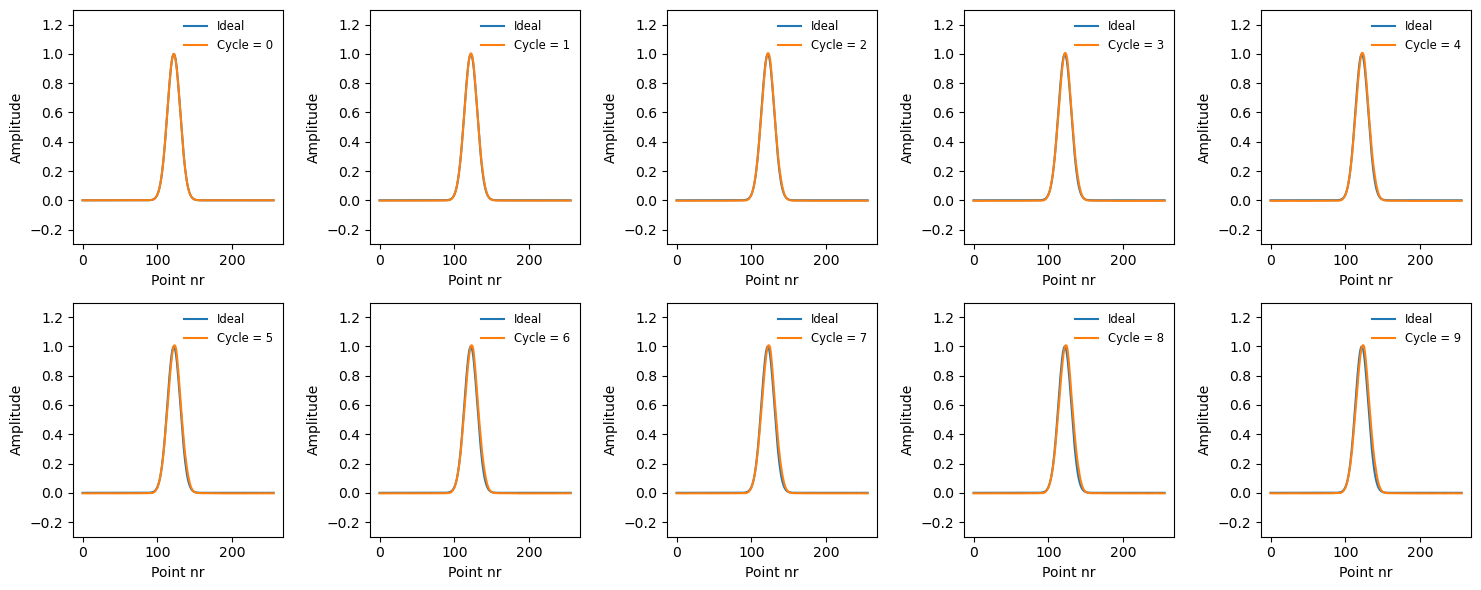

In [117]:
# Rysowanie postępu filtracji - wersja II

# Ustawienia układu subplotów
fig, axs = plt.subplots(2, 5, figsize=(15, 6))  # 2 wiersze, 5 kolumn
signal_nr = 2 # 0..batch_size

# Rysowanie każdego sygnału osobno
for i in range(10):
    row = i // 5  # Wiersz subplotu (0 lub 1)
    col = i % 5   # Kolumna subplotu (0 do 4)
    axs[row, col].plot(signals_prediction[0][signal_nr].cpu().numpy(), label='Ideal')  # Podać pozycję z batch 0..7
    axs[row, col].plot(signals_prediction[i+1][signal_nr].cpu().numpy(), label=f'Cycle = {i}') 
    axs[row, col].set_ylim(-0.3, 1.3)
    axs[row, col].legend(loc='upper right', fontsize='small', framealpha=0.0)
    axs[row, col].set_xlabel('Point nr')
    axs[row, col].set_ylabel('Amplitude')

# Dostosowanie odstępów między wykresami
plt.tight_layout()

# Zapisanie wykresu do pliku
plt.savefig('Progress10.jpg')

# Wyświetlenie wykresów
plt.show()

In [ ]:
11.4/4.6

In [ ]:
# Funkcja Gaussa
def fgauss(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

In [119]:
#signal_nr = 0  # 0..batch_size

# Inicjalizacja buf z 11 pustymi elementami
buf = [None] * 11

# Rysowanie każdego sygnału osobno
for i in range(11):
    buf[i] = signals_prediction[i][signal_nr].cpu().numpy()
    
    # Przyjmijmy, że sygnały są jednowymiarowe, a x to indeksy sygnału
    x = np.arange(len(buf[i]))
    y = buf[i]
    
    # Initial guess for the parameters [amplitude, mean, standard deviation]
    initial_guess = [np.max(y), np.mean(x), np.std(x)]
    initial_guess = [1.0, np.argmax(y), 1.0]
    
    # Dopasowanie krzywej Gaussa
    popt, pcov = curve_fit(fgauss, x, y, p0=initial_guess)
       
    # popt zawiera współczynniki [A, mu, sigma]
    A, mu, sigma = popt
    SN = A / np.std(y[200:250]) # Ustawić przedział !!! dla każdego przypadku
    print(f"Signal {i}: Amplitude = {A:.3f}, Mean = {mu:.3f}, Std Dev = {sigma:.3f}, S/N = {SN:.3f}")

Signal 0: Amplitude = 1.000, Mean = 121.799, Std Dev = 8.612, S/N = 5422089670290040832.000
Signal 1: Amplitude = 1.000, Mean = 121.799, Std Dev = 8.612, S/N = 5422089670290040832.000
Signal 2: Amplitude = 1.000, Mean = 121.930, Std Dev = 8.664, S/N = 7087.340
Signal 3: Amplitude = 1.000, Mean = 122.062, Std Dev = 8.711, S/N = 4638.161
Signal 4: Amplitude = 1.000, Mean = 122.195, Std Dev = 8.754, S/N = 3937.783
Signal 5: Amplitude = 1.000, Mean = 122.329, Std Dev = 8.798, S/N = 3627.575
Signal 6: Amplitude = 1.000, Mean = 122.463, Std Dev = 8.841, S/N = 3504.780
Signal 7: Amplitude = 1.000, Mean = 122.598, Std Dev = 8.884, S/N = 3430.970
Signal 8: Amplitude = 1.000, Mean = 122.734, Std Dev = 8.927, S/N = 3400.557
Signal 9: Amplitude = 1.000, Mean = 122.870, Std Dev = 8.970, S/N = 3372.786
Signal 10: Amplitude = 1.000, Mean = 123.008, Std Dev = 9.013, S/N = 3383.045


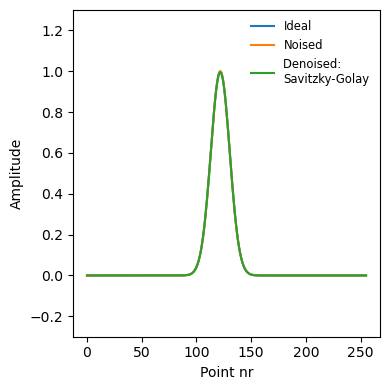

Savitzky-Golay: Amplitude = 0.996, Mean = 121.799, Std Dev = 8.658, S/N = 74708862547167056.000


In [121]:
from scipy.signal import savgol_filter

# Generowanie przykładowego sygnału
x = np.arange(len(buf[1]))
y = buf[1] # zawsze buf[1]

# Parametry filtru Savitzky'ego-Golaya
window_length = 15  # musi być liczbą nieparzystą
polyorder = 3       # rząd wielomianu

# Zastosowanie filtru
y_filtered = savgol_filter(y, window_length, polyorder)

# Wykresy przed i po filtracji
plt.figure(figsize=(4, 4))
plt.plot(x, buf[0], label='Ideal')
plt.plot(x, y, label='Noised') #, color='gray', linestyle='--')
plt.plot(x, y_filtered, label='Denoised: \nSavitzky-Golay') #, color='blue')
plt.ylim(-0.3, 1.3)
plt.legend(loc='upper right', fontsize='small', framealpha=0.0)
plt.xlabel('Point nr')
plt.ylabel('Amplitude')

# Dostosowanie odstępów między wykresami
plt.tight_layout()

#plt.grid(True)
# Zapisanie wykresu do pliku
plt.savefig('SavGolay.jpg')
plt.show()

# Initial guess for the parameters [amplitude, mean, standard deviation]
initial_guess = [np.max(y_filtered), np.mean(x), np.std(x)]
    
    # Dopasowanie krzywej Gaussa
popt, pcov = curve_fit(fgauss, x, y_filtered, p0=initial_guess)
    
    # popt zawiera współczynniki [A, mu, sigma]
A, mu, sigma = popt
SN = A / np.std(y_filtered[200:250]) # Ustawić przedział !!! dla każdego przypadku
print(f"Savitzky-Golay: Amplitude = {A:.3f}, Mean = {mu:.3f}, Std Dev = {sigma:.3f}, S/N = {SN:.3f}")


275


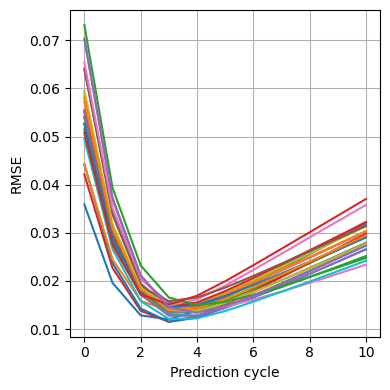

In [123]:
print(len(eval_losses))
# RMSE wartości uśrednione dla każdego batcha
# Rysowanie wykresów dla każdego wiersza
plt.figure(figsize=(4, 4))

# Konwersja listy tensorów na tensor 2D (m x 10)
# `torch.stack` łączy listę tensorów w jeden tensor
eval_losses_tensor = torch.stack(eval_losses)
eval_losses_cpu = eval_losses_tensor.cpu()

points_per_plot = iter_nums+1 #10
for start_index in range(0, len(eval_losses_cpu), points_per_plot):
    end_index = start_index + points_per_plot
    segment = eval_losses_cpu[start_index:end_index]
    plt.plot(segment)

plt.xlabel('Prediction cycle')
plt.ylabel('RMSE')
# Wymuszenie wartości całkowitych na osi X
#plt.xticks(range(1, len(eval_losses_cpu) + 1))
plt.grid(True)

# Dostosowanie odstępów między wykresami
plt.tight_layout()

# Zapisanie wykresu do pliku
plt.savefig('RMSE10.jpg')

# Wyświetlenie wykresu
plt.show()

275


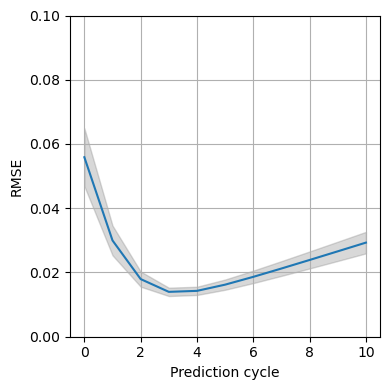

In [125]:
print(len(eval_losses))
# RMSE wartości uśrednione i std

plt.figure(figsize=(4, 4))

# Konwersja listy tensorów na tensor 2D (m x 10)
# `torch.stack` łączy listę tensorów w jeden tensor
eval_losses_tensor = torch.stack(eval_losses)
eval_losses_cpu = eval_losses_tensor.cpu()

points_per_plot = iter_nums + 1  # 10

# Obliczanie średniej i odchylenia standardowego dla segmentu
segment = 0
for start_index in range(0, len(eval_losses_cpu), points_per_plot):
    end_index = start_index + points_per_plot
    segment += eval_losses_cpu[start_index:end_index]
    
mean_segment = segment/(len(eval_losses)/points_per_plot)
#std_segment = segment.std(dim=0)

std_segment = 0
for start_index in range(0, len(eval_losses_cpu), points_per_plot):
    end_index = start_index + points_per_plot
    std_segment += (eval_losses_cpu[start_index:end_index] - mean_segment)**2
    
std_segment = np.sqrt(std_segment/(len(eval_losses)/points_per_plot-1))
    
# Rysowanie średniego wykresu
plt.plot(mean_segment)
    
# Dodanie szarego paska reprezentującego odchylenie standardowe
plt.fill_between(range(points_per_plot), mean_segment - std_segment, mean_segment + std_segment, color='gray', alpha=0.3)

plt.xlabel('Prediction cycle')
plt.ylabel('RMSE')
plt.ylim(0.0, 0.1)
plt.grid(True)

# Dostosowanie odstępów między wykresami
plt.tight_layout()

# Zapisanie wykresu do pliku
plt.savefig('RMSE10mean0.jpg')

# Wyświetlenie wykresu
plt.show()

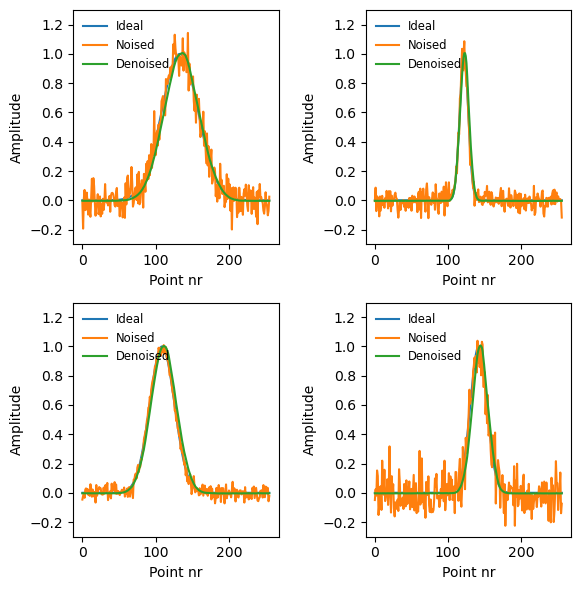

In [127]:
# 4 przykładowe krzywe (jeden batch / 2)

fig, axs = plt.subplots(2, 2, figsize=(6, 6))  

start = 3
for cnr in range(4): # dla batch_size = 8
    x_batch1 = x_batch[start+cnr, :]
    val_y_pred1 = val_y_pred[start+cnr, :] # krzywa po zadanej liczbie cykli predykcji
    gauss1 = gauss[start+cnr, :]
    
    row = cnr // 2  # Określenie wiersza subplot
    col = cnr % 2   # Określenie kolumny subplot
    
    axs[row, col].plot(gauss1.cpu().detach().numpy().T, label='Ideal')
    axs[row, col].plot(x_batch1.cpu().detach().numpy().T, label='Noised')
    axs[row, col].plot(val_y_pred1.cpu().detach().numpy().T, label='Denoised')
    axs[row, col].set_ylim(-0.3, 1.3)
    axs[row, col].set_xlabel('Point nr')
    axs[row, col].set_ylabel('Amplitude')
    axs[row, col].legend(loc='upper left', fontsize='small', framealpha=0.0)

plt.tight_layout()  

# Zapisanie wykresu do pliku
plt.savefig('final_signals.jpg')

plt.show()